In [1]:
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import sklearn
from sklearn.decomposition import PCA

# The data I have yet to "feature-ize"

## Amino Acid-level features
1. Amino Acid Modifications
2. Secondary Structure
3. Amino Acid Disorder

## Protein-level features
1. ~~Subcellular localization~~ - This journal!
2. ~~Tissue expression~~ - This journal!
3. Protein-level characterisics
    * Molecular weight
    * Isoelectric Point
    * Melting Temp
    * Aromaticity
    * Instability Index
    * Molecular Extinction Coefficient
    * Secondary Structure Fraction
4. Protein overall disorder

Lets start with the protein level features for simplicity's sake.

In [2]:
conn = sqlite3.connect("human_protein.db")
subloc_df = pd.read_sql('select * from protein_subcellular_localization', con=conn)
conn.close()
#conn = sqlite3.connect("protein_training.db")
#conn.close()
subloc_df.sample(5)

,protein,subcellular_loc
26851,NDUS8_HUMAN,Mitochondrion
33726,1C16_HUMAN,Cell membrane
10451,CBPC6_HUMAN,Cilium basal body
22347,NAL12_HUMAN,Cytoplasm
32794,AEN_HUMAN,Nucleolus


In [3]:
# Parse keywords to columns
def keywordBinarizer(df, index, keyword):
    key_low = keyword.lower().replace(" ","_").strip()
    if key_low not in df.columns:
        df.loc[:,key_low] = 0
    df.loc[index, key_low] = 1

subloc_df.apply(lambda row: keywordBinarizer(subloc_df, row.name, row.subcellular_loc), axis=1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
34680    None
34681    None
34682    None
34683    None
34684    None
34685    None
34686    None
34687    None
34688    None
34689    None
34690    None
34691    None
34692    None
34693    None
34694    None
34695    None
34696    None
34697    None
34698    None
34699    None
34700    None
34701    None
34702    None
34703    None
34704    None
34705    None
34706    None
34707    None
34708    None
34709    None
Length: 34710, dtype: object

In [4]:
subloc_binar = subloc_df.drop('subcellular_loc',axis=1)
subloc_binar_grouped = subloc_binar.groupby('protein').agg('sum')

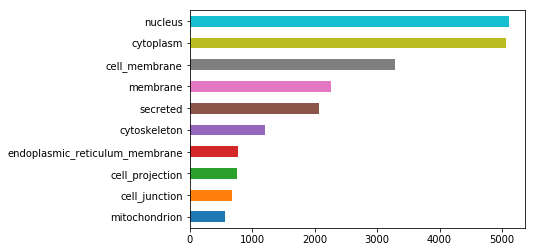

In [5]:
loc_sum = subloc_binar_grouped.sum(axis=0).sort_values()
loc_sum.iloc[-10:].plot.barh()

### Lets see if we can eliminate any of these words for being low in information.

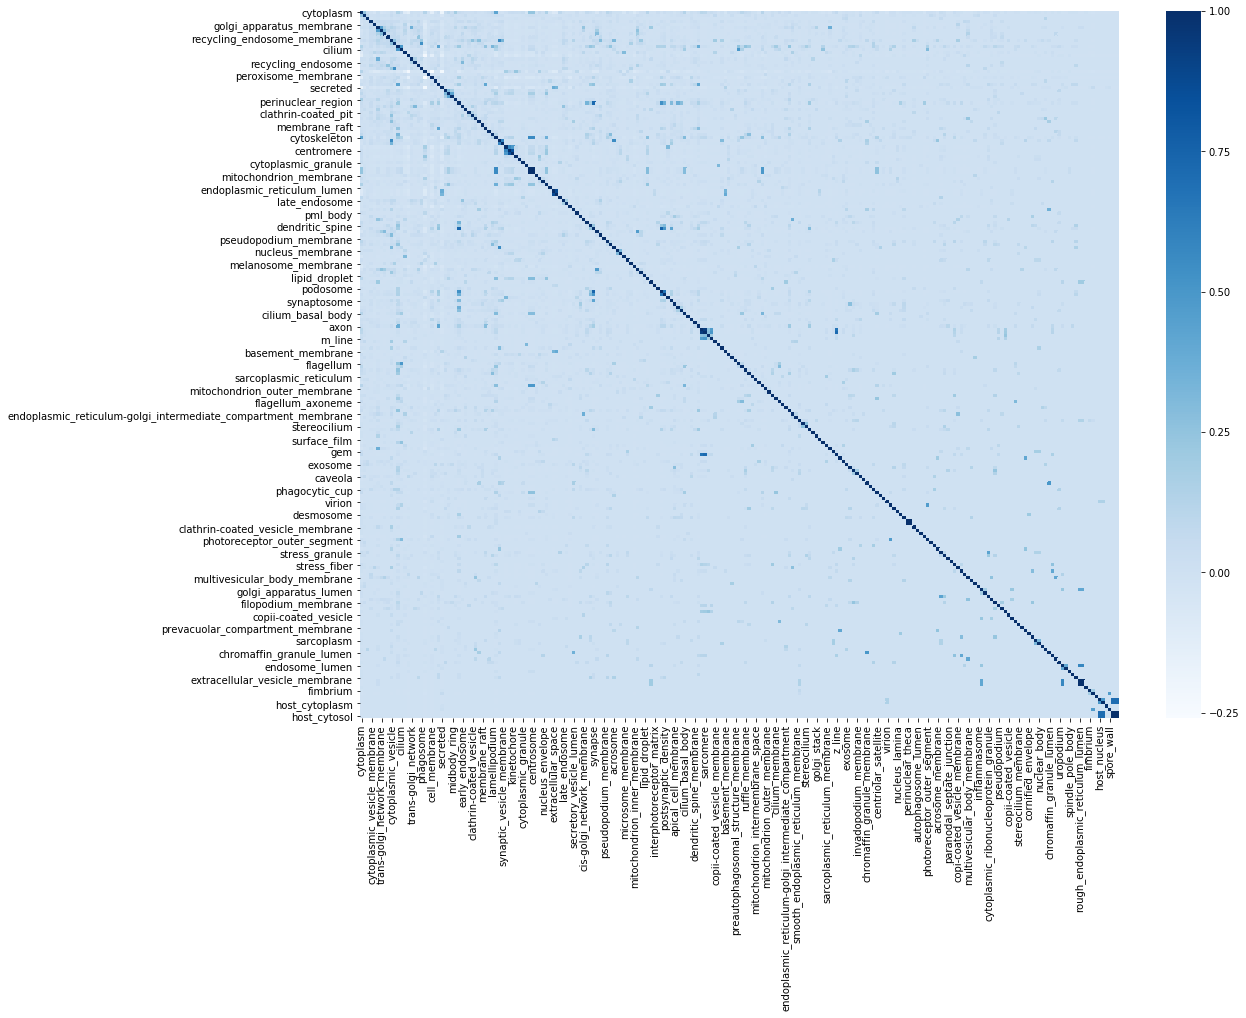

In [6]:
fig, ax = plt.subplots(figsize=(17,13))
subloc_corr = subloc_binar_grouped.corr()
sns.heatmap(subloc_corr,ax=ax, cmap="Blues")

In [7]:
subloc_corr_stacked = subloc_corr.stack().drop_duplicates()
drop_cols = subloc_corr_stacked[
    (subloc_corr_stacked<1.0) & (subloc_corr_stacked>=0.95)] \
    .abs().sort_values(ascending=False).reset_index()

In [8]:
drop_col = drop_cols.iloc[:,0].values.tolist()[0]

In [12]:
subloc_binar_nocorr = subloc_binar_grouped.drop(drop_col,axis=1).reset_index()
subloc_binar_nocorr.head()

,protein,cytoplasm,cytosol,rough_endoplasmic_reticulum,cytoplasmic_vesicle_membrane,golgi_apparatus_membrane,golgi_apparatus,trans-golgi_network_membrane,endosome_membrane,recycling_endosome_membrane,...,nucleoid,fimbrium,cell_wall,host_golgi_apparatus_membrane,host_nucleus,host_cytoplasm,forespore_intermembrane_space,spore_wall,host_mitochondrion_inner_membrane,host_cytosol
0,1433B_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1433E_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1433G_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1433S_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1433T_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
subloc_binar_nocorr.columns = ["loc_"+x if x != "protein" else x for x in subloc_binar_nocorr.columns]

In [15]:
subloc_binar_nocorr.head()

,protein,loc_cytoplasm,loc_cytosol,loc_rough_endoplasmic_reticulum,loc_cytoplasmic_vesicle_membrane,loc_golgi_apparatus_membrane,loc_golgi_apparatus,loc_trans-golgi_network_membrane,loc_endosome_membrane,loc_recycling_endosome_membrane,...,loc_nucleoid,loc_fimbrium,loc_cell_wall,loc_host_golgi_apparatus_membrane,loc_host_nucleus,loc_host_cytoplasm,loc_forespore_intermembrane_space,loc_spore_wall,loc_host_mitochondrion_inner_membrane,loc_host_cytosol
0,1433B_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1433E_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1433G_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1433S_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1433T_HUMAN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
conn = sqlite3.connect("protein_training.db")
subloc_binar_nocorr.to_sql('protein_subloc', index=False, con=conn, if_exists='replace')
conn.close()

In [17]:
conn = sqlite3.connect("human_protein.db")
tissue_df = pd.read_sql('select * from protein_tissue_expression', con=conn)
conn.close()
tissue_df.sample(5)

,protein,disease
2731,BMPR2_HUMAN,Highly expressed in heart and liver.
8000,CTGE2_HUMAN,Testis. Not found in tumor.
7496,NTH_HUMAN,Widely expressed with highest levels in heart ...
7123,RPN2_HUMAN,Expressed in all tissues tested.
8449,PADI1_HUMAN,"Epidermis, prostate, testis, placenta, spleen ..."


In [18]:
docs = tissue_df.disease.tolist()
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer('content')
docs_tfidf_transformed = tf_idf_vectorizer.fit_transform(docs)
docs_tfidf_df = pd.DataFrame(docs_tfidf_transformed.toarray(), columns=tf_idf_vectorizer.get_feature_names(), index=tissue_df.protein)
docs_tfidf_df = docs_tfidf_df[docs_tfidf_df.index.duplicated()==False]
print(docs_tfidf_df.shape)
docs_tfidf_df.head()

(9712, 5326)


,01,02,07e,10,100,1000,10087195,10087202,10092508,101,...,yt,zdhhc17,zeb1,zeta,zmpste24,zona,zone,zones,zr,zymogen
protein,,,,,,,,,,,,,,,,,,,,,
PYRG1_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB43_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB2B_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB36_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB17_HUMAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Find top 100 terms, this matrix is too unwieldy otherwise.

In [19]:
term_array = np.array(tf_idf_vectorizer.get_feature_names())
tfidf_sorted = np.argsort(docs_tfidf_transformed.toarray()).flatten()[::-1]

n = 100
top_n = term_array[tfidf_sorted][:n]

In [20]:
docs_tfidf_df_top_n = docs_tfidf_df[top_n]
docs_tfidf_df_top_n.head()

,glands,skin,by,the,expressed,concentrations,conditions,cone,cones,confined,...,circular,circulates,circulating,circumvallate,cirrhotic,cisplatin,cla,clara,class,classical
protein,,,,,,,,,,,,,,,,,,,,,
PYRG1_HUMAN,0.0,0.0,0.0,0.0,0.386972,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB43_HUMAN,0.0,0.0,0.0,0.0,0.113534,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB2B_HUMAN,0.0,0.0,0.0,0.0,0.083868,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB36_HUMAN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB17_HUMAN,0.0,0.0,0.0,0.0,0.164799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
docs_tfidf_df_top_n_corr = docs_tfidf_df_top_n.corr()

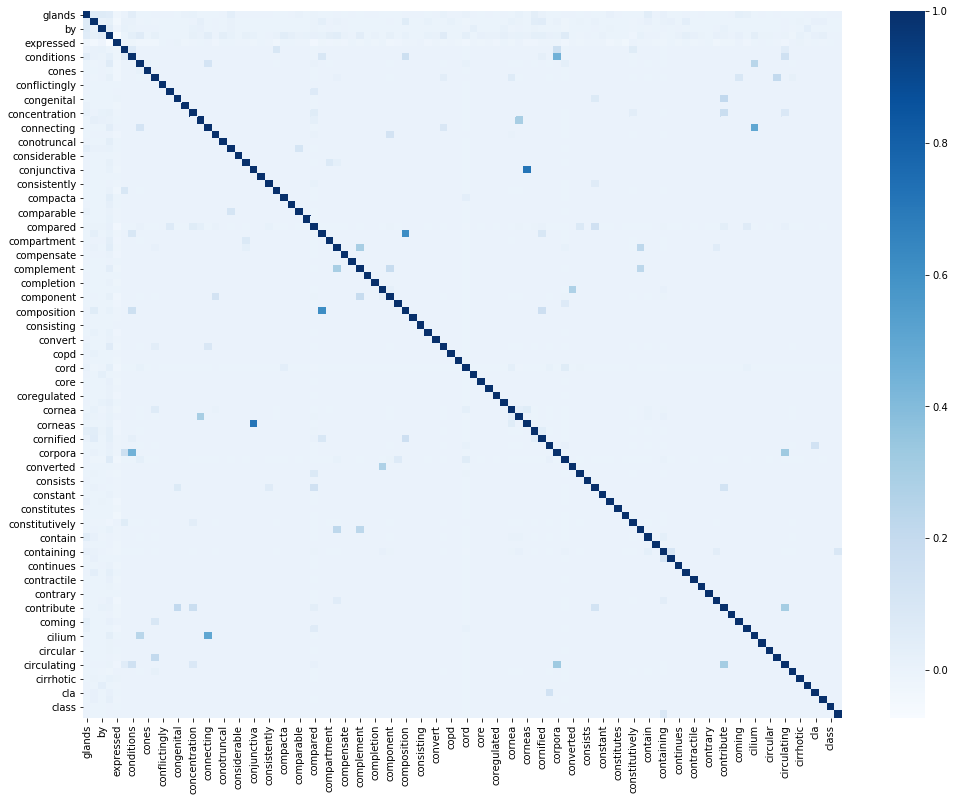

In [22]:
fig, ax = plt.subplots(figsize=(17,13))
sns.heatmap(docs_tfidf_df_top_n_corr,ax=ax, cmap="Blues")

In [23]:
docs_tfidf_df_top_n_corr_stacked = docs_tfidf_df_top_n_corr.stack().drop_duplicates()
tfidf_drop_cols = docs_tfidf_df_top_n_corr_stacked[
    (docs_tfidf_df_top_n_corr_stacked<1.0) &
    (docs_tfidf_df_top_n_corr_stacked>=0.95)
].abs().sort_values(ascending=False).reset_index()

In [27]:
docs_tfidf_df_top_n.columns = ["exp_"+x if x != "protein" else x for x in docs_tfidf_df_top_n.columns]

In [28]:
docs_tfidf_df_top_n.head()

,exp_glands,exp_skin,exp_by,exp_the,exp_expressed,exp_concentrations,exp_conditions,exp_cone,exp_cones,exp_confined,...,exp_circular,exp_circulates,exp_circulating,exp_circumvallate,exp_cirrhotic,exp_cisplatin,exp_cla,exp_clara,exp_class,exp_classical
protein,,,,,,,,,,,,,,,,,,,,,
PYRG1_HUMAN,0.0,0.0,0.0,0.0,0.386972,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB43_HUMAN,0.0,0.0,0.0,0.0,0.113534,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB2B_HUMAN,0.0,0.0,0.0,0.0,0.083868,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB36_HUMAN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAB17_HUMAN,0.0,0.0,0.0,0.0,0.164799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Looks like we can keep them all!

In [29]:
conn = sqlite3.connect("protein_training.db")
docs_tfidf_df_top_n.to_sql('protein_tissue_exp_keywords', index=True, con=conn, if_exists='replace')
conn.close()